In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date

Preprocess

In [79]:
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/working/Data_working.csv")
#cac gia tri row > 4658 duoc xoa -> NULL
total = total.loc[:4658,:] 
#dien cac gia tri con thieu
total = total.fillna(method='ffill')
for index in total.index:
  total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%d/%m/%Y').date()
print(total.head())


         Date  BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume   
0  2023-04-16    30310.3   30299.2   30545.3  30134.6       34.48  \
1  2023-04-15    30299.6   30472.6   30586.5  30208.8       31.71   
2  2023-04-14    30472.5   30387.4   30964.9  30026.0       98.38   
3  2023-04-13    30387.4   29892.4   30524.1  29864.5       65.87   
4  2023-04-12    29886.4   30209.8   30473.0  29679.5       78.69   

   Active_Addr_Cnt    Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
0         840992.0  4.788780e+13                1866594.290       495223185.0  \
1        1045660.0  4.788780e+13                1839875.354       631025193.0   
2        1016042.0  4.788780e+13                1759535.436       559166432.0   
3        1009669.0  4.788780e+13                1812112.549       567094231.0   
4        1056542.0  4.788780e+13                1933495.919       635037442.0   

   ...      ETH     LTC      DOGE      XRP    GOLD  SILVER  COOPER   S&P500   
0  ...  2119.29  10

In [80]:
#ETH ra doi ngay 30/7/2015, random 1 date sau do
#Biểu đồ giá đóng cửa Bitcoin (BTC) cho thấy một mô hình tương đối bằng phẳng trong dữ liệu từ tháng 9 năm 2014 đến tháng 7 năm 2016, 
#sau đó là đợt tăng giá mạnh từ tháng 9 năm 2017 đến tháng 1 năm 2018
Start_day = date(2015, 9, 1)
Test_day = date(2018,6,30)
#chon ra 20-25% data trong giai doan 1
End_day = date(2018,9,30)
# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day) ].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)
print(test_dataset.head())
print(test_dataset.tail())

         Date  BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume   
0  2018-09-30     6635.2    6603.9    6673.9   6533.5        9.34  \
1  2018-09-29     6603.9    6633.9    6648.4   6464.4        9.42   
2  2018-09-28     6636.0    6685.7    6809.2   6538.6        9.57   
3  2018-09-27     6689.2    6463.7    6738.3   6428.8        9.34   
4  2018-09-26     6468.1    6443.0    6551.9   6384.1        8.64   

   Active_Addr_Cnt    Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
0         514766.0  7.152630e+12                610653.1472       330287157.0  \
1         564628.0  7.152630e+12                709309.6184       355787307.0   
2         654875.0  7.152630e+12                835734.5195       422560874.0   
3         642476.0  7.152630e+12                887769.7133       414744804.0   
4         624467.0  7.152630e+12                894936.2086       406826648.0   

   ...     ETH     LTC      DOGE      XRP    GOLD  SILVER   COOPER   S&P500   
0  ...  232.80  61.

In [81]:
X_train = train_dataset.drop(["Date"], axis=1)[:-1]
Y_train = train_dataset["BTC_close"][1:]

X_test = test_dataset.drop(["Date"], axis=1)[:-1]
Y_test = test_dataset["BTC_close"][1:]

Model

In [82]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [83]:
simpleTree = RandomForestRegressor(max_depth=15, n_estimators=500)
#Xây dựng cây hồi quy với độ sâu cây là 10 (Random forest), 500 cây
simpleTree.fit(X_train, Y_train)

RandomForestRegressor(max_depth=15, n_estimators=500)

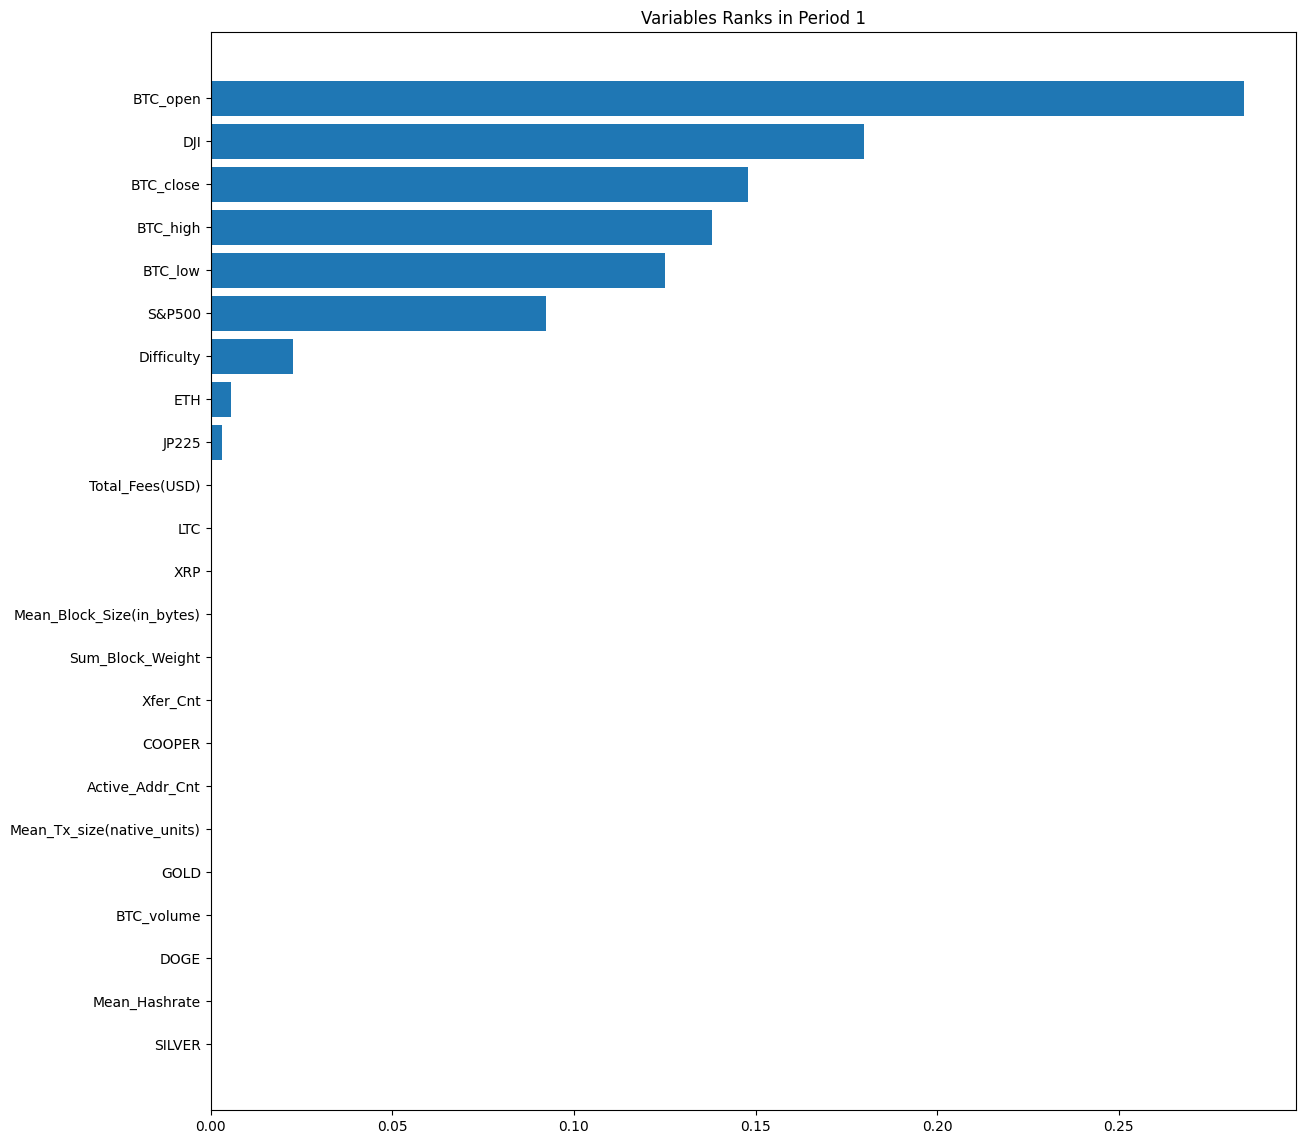

In [84]:
# Importance of variables
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(14,14))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.title("Variables Ranks in Period 1")
plt.show()

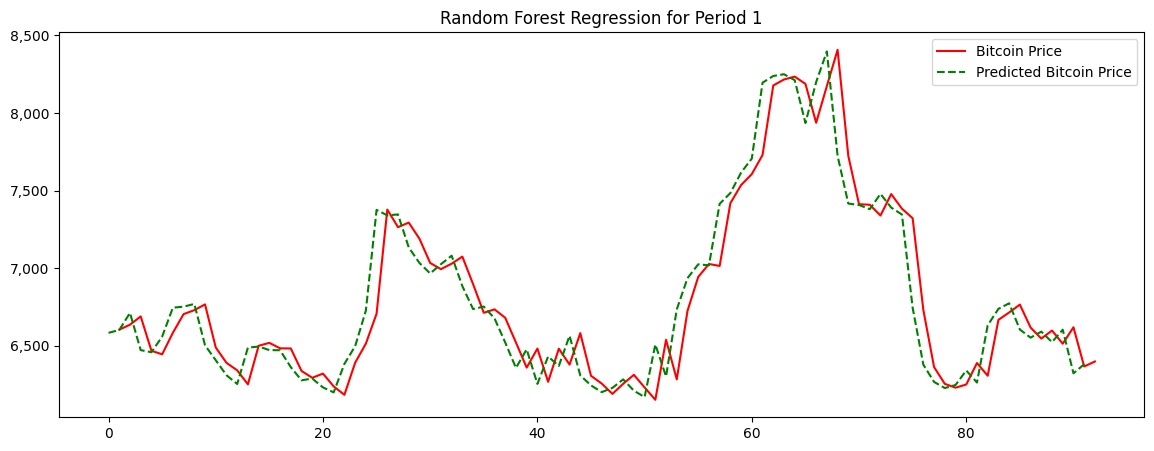

In [85]:
#so sanh cac gia tri du doan va quan sat
Y_pred = simpleTree.predict(X_test)
#hien thi ket qua du doan
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(Y_test, color = 'red', label="Bitcoin Price")
ax.plot(Y_pred, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()

In [86]:
#tinh toan loi du doan
#RMSE
from sklearn.metrics import mean_squared_error
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print()

#MAPE
MAPE = np.average(np.abs((Y_test.values - Y_pred) / Y_test.values))
print("MAPE:", MAPE)
print()

#DA
Y_test_DA = np.array(Y_test)
Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
Y_test_0 = Y_test[1:] - Y_test_DA[:-1]
DA = (Y_pred_0<0) == (Y_test_0<0)
print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")

RMSE: 22.99418852119397

MAPE: 0.0026063497496810113

DA accuracy: 96.7%


In [87]:
n_jobs = -1

In [88]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=750, n_jobs=n_jobs, random_state=42)
forest.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=750, n_jobs=-1, random_state=42)

In [89]:
import time
import matplotlib.pyplot as plt

start_time = time.time()
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
importances = forest.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.117 seconds


In [90]:
#total_without_date = total.drop('Date', axis=1)
#total_without_date 

In [91]:
#total_without_date.corr()

<Axes: >

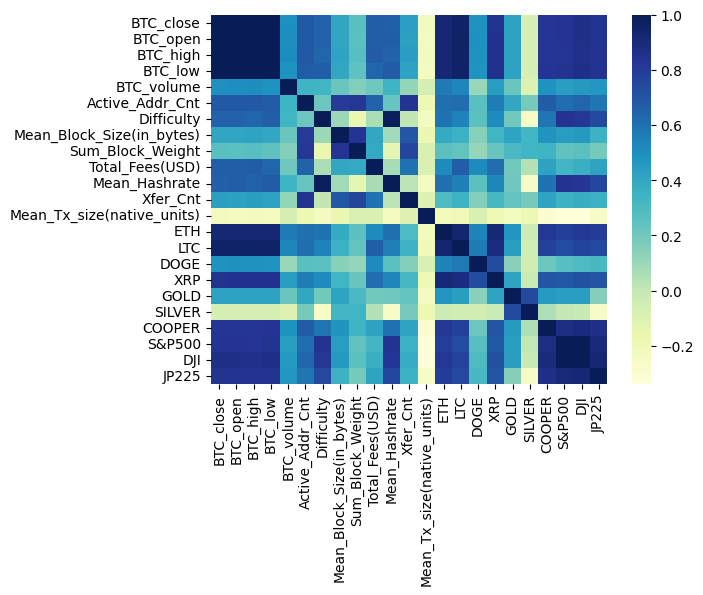

In [99]:
import seaborn as sns
#sns.heatmap(total_without_date.corr(), cmap="viridis")
#sns.heatmap(total_without_date.corr(), cmap="plasma")
#sns.heatmap(total_without_date.corr(), cmap="inferno")
#sns.heatmap(total_without_date.corr(), cmap="magma")
#sns.heatmap(total_without_date.corr(), cmap="cividis")
#sns.heatmap(total_without_date.corr(), cmap="RdBu")
sns.heatmap(total_without_date.corr(), cmap="YlGnBu")
#sns.heatmap(total_without_date.corr(), cmap="YlOrBr")

